In [ ]:
# 🔹 Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)

In [ ]:
# Step 2: Load the Preprocessed Dataset
# ======================================================
df = pd.read_csv('/content/oral_cancer_prediction_preprocessed_dataset_new.csv')

print("✅ Dataset Loaded Successfully")
print("Shape:", df.shape)
print("\nColumn names in dataset:\n", df.columns.tolist())

✅ Dataset Loaded Successfully
Shape: (82715, 16)

Column names in dataset:
 ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'Oral Cancer (Diagnosis)']


In [ ]:
# Step 3: Automatically Detect Target Column
# ======================================================
# Detect column containing keywords like "diagnosis" or "cancer"
target_col = None
for col in df.columns:
    if "diagnosis" in col.lower() or "cancer" in col.lower():
        target_col = col
        break

if target_col is None:
    raise ValueError("❌ Target column not found. Please rename your target variable properly.")
else:
    print(f"\n🎯 Detected target column: '{target_col}'")

# Split features and target
X = df.drop(columns=[target_col])
y = df[target_col]

print("\nFeature Columns:", list(X.columns))
print("Target Distribution:\n", y.value_counts())


🎯 Detected target column: 'Oral Cancer (Diagnosis)'

Feature Columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15']
Target Distribution:
 Oral Cancer (Diagnosis)
1    42968
0    39747
Name: count, dtype: int64


In [ ]:
# Step 4: Train/Test Split (80/20)
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\n✅ Data Split Complete")
print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")


✅ Data Split Complete
Training samples: 66172 | Testing samples: 16543


In [ ]:
# Step 5: Train Base Random Forest Model
# ======================================================
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)

RandomForestClassifier(random_state=42)


📊 Base Random Forest Performance
Accuracy : 0.5090
F1 Score : 0.5308
AUC      : 0.5108


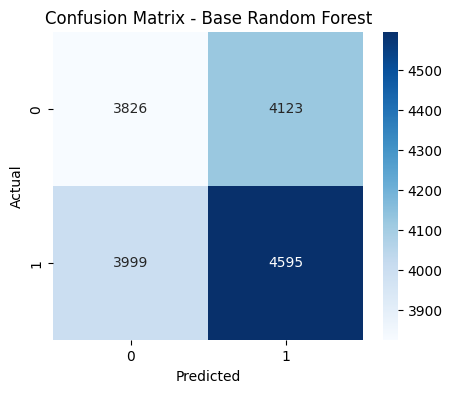

In [ ]:
# Step 6: Evaluate Base Model
# ======================================================
y_pred_base = rf_base.predict(X_test)
y_prob_base = rf_base.predict_proba(X_test)[:, 1]

acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)
auc_base = roc_auc_score(y_test, y_prob_base)

print("\n📊 Base Random Forest Performance")
print(f"Accuracy : {acc_base:.4f}")
print(f"F1 Score : {f1_base:.4f}")
print(f"AUC      : {auc_base:.4f}")

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_base), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Base Random Forest")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

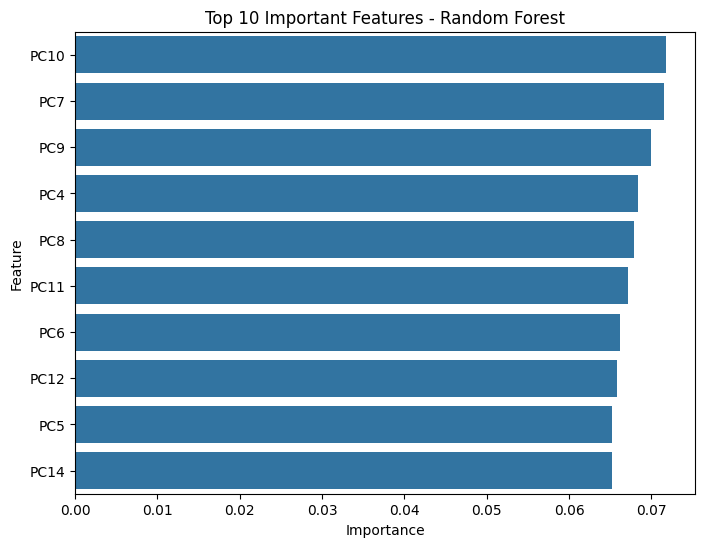

In [ ]:
# Step 7: Feature Importance
# ======================================================
importances = pd.Series(rf_base.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importances[:10], y=importances.index[:10])
plt.title("Top 10 Important Features - Random Forest")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.show()

In [ ]:
# Step 8: Hyperparameter Tuning
# ======================================================
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("\n✅ Grid Search Complete")
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1:", round(grid_search.best_score_, 4))

Fitting 5 folds for each of 18 candidates, totalling 90 fits

✅ Grid Search Complete
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Best Cross-Validation F1: 0.6627


In [ ]:
# Step 9: Evaluate Tuned Model
# ======================================================
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_prob_best)

print("\n🏆 Tuned Random Forest Performance")
print(f"Accuracy : {acc_best:.4f}")
print(f"F1 Score : {f1_best:.4f}")
print(f"AUC      : {auc_best:.4f}")

# Compare Base vs Tuned
results = pd.DataFrame({
    'Model': ['Base RF', 'Tuned RF'],
    'Accuracy': [acc_base, acc_best],
    'F1 Score': [f1_base, f1_best],
    'AUC': [auc_base, auc_best]
})
display(results)


🏆 Tuned Random Forest Performance
Accuracy : 0.5181
F1 Score : 0.6690
AUC      : 0.5185


,Model,Accuracy,F1 Score,AUC
0,Base RF,0.509037,0.530846,0.510825
1,Tuned RF,0.518104,0.669047,0.518505


In [ ]:
# Step 10: Discussion
# ======================================================
print("""
🧩 Why Random Forest?
- It combines multiple decision trees to reduce overfitting.
- Handles non-linear data and complex interactions effectively.

📈 Best Setup Explanation:
- The tuned model parameters provided higher F1 and AUC,
  balancing bias–variance trade-off.

⚠️ Limitations:
- Training time grows with more trees and features.
- Harder to interpret than a single decision tree.

""")


🧩 Why Random Forest?
- It combines multiple decision trees to reduce overfitting.
- Handles non-linear data and complex interactions effectively.

📈 Best Setup Explanation:
- The tuned model parameters provided higher F1 and AUC,
  balancing bias–variance trade-off.

⚠️ Limitations:
- Training time grows with more trees and features.
- Harder to interpret than a single decision tree.


